In [2]:
# Основные библиотеки
import os
import warnings
import copy
import numpy as np
import pandas as pd

# Библиотеки для работы с изображениями и DICOM
import pydicom
import pydicom.data
from pydicom.pixel_data_handlers.util import apply_voi_lut, apply_color_lut, apply_modality_lut
import gdcm  # Для работы с DICOM-файлами, у которых было использовано сжатие массива пикселей
import cv2
from PIL import Image
from scipy.ndimage import zoom

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Библиотеки для работы с данными и массивами
from skimage import measure, morphology
import scipy

# Библиотеки для работы с файлами и прогресс-барами
from glob import glob
import itertools
from tqdm import tqdm
import tqdm.notebook as tqdm_notebook

# Константы
IMAGE_SIZE = (150, 150)
BRAIN_HU = (22, 50)
BONES_HU = (220, 2000)
BLOOD_HU = (50, 75)
BASE = r"M:\Diplom"

warnings.filterwarnings("ignore") # Игнорируем ошибки, чтобы они не забивали вывод


In [3]:
#Получение серии снимков из указанной директории
def get_dcm_serie(path_to_dcm_serie : str, show_info = True):
    ds_list = []
    dcm_files = os.listdir(path_to_dcm_serie)
    for file in dcm_files:
        buf_ds_file = pydicom.dcmread(path_to_dcm_serie+'/'+file, force=True)
        ds_list.append(buf_ds_file)

    if 'SamplesPerPixel' not in ds_list[0]:
        for el in ds_list:
            el.SamplesPerPixel = int(len(el.PixelData) / (el.get('NumberOfFrames', 1) * el.Rows * el.Columns * el.BitsAllocated / 8))
    if 'PhotometricInterpretation' not in ds_list[0]:
        for el in ds_list:
            el.PhotometricInterpretation = 'MONOCHROME2'
    if 'RescaleSlope' not in ds_list[0]:
        for el in ds_list:
            el.RescaleSlope = 1

    try:
        slice_thickness = np.abs(ds_list[0].ImagePositionPatient[2] - ds_list[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(ds_list[0].SliceLocation - ds_list[1].SliceLocation)

    for el in ds_list:
        el.SliceThickness = slice_thickness

    if show_info:
        print(f'Кол-во снимков = {len(ds_list)}, uid={path_to_dcm_serie.split('\\')[-1]}')

    return sorted(ds_list, key=lambda s: s.ImagePositionPatient[2])

#Получение серии снимков из указанной директории
def get_dcm_serie_new(path_to_dcm_serie : str):
    ds_list = []
    dcm_files = os.listdir(path_to_dcm_serie)
    for file in dcm_files:
        buf_ds_file = pydicom.dcmread(path_to_dcm_serie+'/'+file)
        #Проверяем, аксиальная ли проекция у снимка (иногда в датасетах появляются сагитальные и корональные снимки)
        if ("ImageType" in buf_ds_file) == False:
            ds_list.append(buf_ds_file)
        elif buf_ds_file.ImageType[-1] == 'AXIAL':
            ds_list.append(buf_ds_file)
    print(f'Кол-во снимков = {len(ds_list)}')
    if len(ds_list) > 0:
        ds_list = sorted(ds_list, key=lambda s: s.ImagePositionPatient[2])
        try:
            slice_thickness = np.abs(ds_list[0].ImagePositionPatient[2] - ds_list[1].ImagePositionPatient[2])
        except:
            slice_thickness = np.abs(ds_list[0].SliceLocation - ds_list[1].SliceLocation)
        for s in ds_list:
            s.SliceThickness = slice_thickness
    return ds_list


#Функция, которая увличивает контрастность изображений (костная ткань становится видна лучше) и изменяет их размер
def resize_and_voi_lut(dcm_file):
    if 'SamplesPerPixel' not in dcm_file:
        dcm_file.SamplesPerPixel = len(dcm_file.PixelData) / (dcm_file.get('NumberOfFrames', 1) * dcm_file.Rows * dcm_file.Columns * dcm_file.BitsAllocated / 8)
    if 'PhotometricInterpretation' not in dcm_file:
        dcm_file.PhotometricInterpretation = 'MONOCHROME2'
    buf_pixel_array = apply_voi_lut(dcm_file.pixel_array, dcm_file)
    resized_array = cv2.resize(buf_pixel_array, IMAGE_SIZE, interpolation = cv2.INTER_NEAREST)
    return resized_array

def get_pixels_hu(slices):
    #image = np.stack([cv2.resize(s.pixel_array, IMAGE_SIZE, interpolation = cv2.INTER_NEAREST) for s in slices])
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    # Преобразование в Hounsfield Units (HU)
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

def hu_good_pixels(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def read_all_excel_dataframes(directory):
    all_data = []

    # Обход всех файлов и папок в указанном каталоге
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.xlsx'):
                file_path = os.path.join(root, file)
                print(f"Reading file: {file_path}")

                # Чтение Excel-файла
                df = pd.read_excel(file_path)
                print(len(df))
                all_data.append(df)

    return all_data

def find_folder(directory, folder_name):
    for root, dirs, files in os.walk(directory):
        if folder_name in dirs:
            return os.path.join(root, folder_name)
    return None

# Функция для вывода нескольких проекций (аксиальной, сагитальной, корональной)
def get_proections(ds_list):
    ds_list = sorted(ds_list, key=lambda s: s.ImagePositionPatient[2])

    # Проверяем, что все срезы имеют одинаковые характеристики
    ps = ds_list[0].PixelSpacing
    ss = ds_list[0].SliceThickness
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]

    # Создаем трехмерный массив
    img_shape = list(ds_list[0].pixel_array.shape)
    img_shape.append(len(ds_list))
    img3d=np.zeros(img_shape)
    #print(ds_list[0].pixel_array.shape)

    # Заполняем трехмерный массив нашими снимками (срезами), увеличивая при этом их контрастность
    for i, s in enumerate(ds_list):
        img2d = apply_voi_lut(s.pixel_array, s)
        img3d[:,:,i] = img2d

    # АКСИАЛЬНАЯ ПРОЕКЦИЯ
    a1 = plt.subplot(1,3, 1)
    a1.set_title('Аксиальная', fontsize=14, fontweight='bold')
    a1.axis('off')
    plt.imshow(img3d[:,:,img_shape[2]//2], cmap = 'bone')
    a1.set_aspect(ax_aspect)

    # САГИТАЛЬНАЯ ПРОЕКЦИЯ
    a2 = plt.subplot(1,3, 2)
    a2.set_title('Сагитальная', fontsize=14, fontweight='bold')
    a2.axis('off')
    plt.imshow(img3d[:,img_shape[1]//2,:], cmap = 'bone')
    a2.set_aspect(sag_aspect)

    # КОРОНАЛЬНАЯ ПРОЕКЦИЯ
    a3 = plt.subplot(1,3, 3)
    a3.set_title('Корональная', fontsize=14, fontweight='bold')
    a3.axis('off')
    plt.imshow(img3d[img_shape[0]//2,:,:].T, cmap = 'bone')
    a3.set_aspect(cor_aspect)

    plt.suptitle('Проекции')
    plt.tight_layout()
    plt.show()

def resize_dicom_list(ds_list):
    return np.array([cv2.resize(x.pixel_array, IMAGE_SIZE, interpolation = cv2.INTER_NEAREST) for x in ds_list])

def hu_good_pixels(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    #print(counts)
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def resample(image, scan, new_spacing=[1,1,1]):
    print(type([scan[0].SliceThickness]))
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

def segment_hu_mask(image, hu_threshold, fill_bone_structures=True):
    # Указываем по шкале Хаунсфилда, какие ткани нам нужны
    binary_image = np.logical_not(np.logical_and(image > hu_threshold[0], image < hu_threshold[1])).astype(np.int8) + 1
    labels = measure.label(binary_image)

    background_label = labels[0,0,0]

    binary_image[background_label == labels] = 2

    if fill_bone_structures:
        fill_structures(binary_image)
    
    binary_image -= 1
    binary_image = 1-binary_image

    for i, axial_slice in enumerate(binary_image):
        labels = measure.label(axial_slice, background=0)
        l_max = hu_good_pixels(labels, bg=0)
        if l_max is not None:
            binary_image[i][labels != l_max] = 0
    
    return binary_image

def fill_structures(binary_image):
    binary_image_buf = binary_image - 1
    labels = measure.label(binary_image_buf, background=0)
    l_max = hu_good_pixels(labels, bg=0)
    if l_max is not None:
        binary_image[labels != l_max] = 0

    return binary_image

def get_structures_only(images, hu_threshold):
    result = images.copy()
    segmented_structures_fill = segment_hu_mask(result, hu_threshold, fill_bone_structures=True)

    # Изолируем ткани
    for i, mask in enumerate(segmented_structures_fill):
        get_high_vals = mask == 0
        result[i][get_high_vals] = 0

    return result

def plot_hu(images):
    plt.hist(images.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

def resize_array(array):
    # Определяем коэффициенты сжатия для каждой оси
    zoom_factors = (128 / array.shape[0], 1, 1)
    # Применяем интерполяцию
    resized_array = zoom(array, zoom_factors, order=1)
    return resized_array

def get_stacked_structures_from_dicom(dicom_list):
    patient_pixels = resize_dicom_list(dicom_list)

    brain = resize_array(get_structures_only(patient_pixels, BRAIN_HU))
    bones = resize_array(get_structures_only(patient_pixels, BONES_HU))
    blood = resize_array(get_structures_only(patient_pixels, BLOOD_HU))

    stacked_image = np.stack((brain, bones, blood), axis=0)

    return stacked_image

def get_many_brain_proections(df, rows=5, cols=5):
    N = rows*cols
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24,15))

    for i in range(N):
        brain_num = np.random.randint(0, 800)
        brain = get_dcm_serie(glob(find_folder(BASE, df['study_uid'][brain_num])+'/*')[-1],
                               show_info = False)
        slice_num = len(brain) // 2

        patient_dicoms = brain[slice_num:slice_num+1]
        patient_pixels = resize_dicom_list(patient_dicoms)
        only_brain = get_structures_only(patient_pixels, BRAIN_HU)

        # Размещаем изображения по строкам и столбцам
        x = i // cols
        y = i % cols

        axes[x, y].imshow(only_brain[0], cmap="bone")
        axes[x, y].set_title(f"Снимок: {brain_num}, Кровь: {df['ICH'][brain_num]}",
                  fontsize=14, weight='bold')
        axes[x, y].axis('off')

In [3]:
data_frames = read_all_excel_dataframes(BASE)

# Объединение всех DataFrame в один, если это необходимо
if data_frames:
    combined_df = pd.concat(data_frames, ignore_index=True)
else:
    print("No .xlsx files found.")

Reading file: M:\Diplom\0_100_studies\labeling_0.xlsx
100
Reading file: M:\Diplom\100_200_studies\labeling_7.xlsx
100
Reading file: M:\Diplom\200_300_studies\labeling.xlsx
100
Reading file: M:\Diplom\300_400_studies\labeling_3.xlsx
100
Reading file: M:\Diplom\400_500_studies\labeling.xlsx
100
Reading file: M:\Diplom\500_600_studies\labeling_4.xlsx
100
Reading file: M:\Diplom\600_700_studies\labeling_6.xlsx
100
Reading file: M:\Diplom\700_800_studies\labeling_1.xlsx
100


In [4]:
combined_df[combined_df['ICH'].isna()]

,study_uid,Radiology text report (in russian),ICH,epidural hemorrhage,subarachnoid hemorrhage,subdural hemorrhage,intracerebral hemorrhage,multiple hemorrhages,skull fracture,combined pathologies,break in the cerebrospinal fluid spaces,Comment,comment
200,1.2.643.5.1.13.13.12.2.77.8252.000015101204131...,На момент исследования данных за свежие зоны и...,NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
201,1.2.643.5.1.13.13.12.2.77.8252.000211060009131...,"На серии томограмм , выполненных в аксиальной ...",NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
202,1.2.643.5.1.13.13.12.2.77.8252.000403090703050...,КЛИНИЧЕСКАЯ ИНФОРМАЦИЯ : Состояние после закры...,NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
203,1.2.643.5.1.13.13.12.2.77.8252.000515100506000...,"На серии томограмм , выполненных в аксиальной ...",NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
204,1.2.643.5.1.13.13.12.2.77.8252.000612120711000...,Срединные структуры не смещены . На момент исс...,NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.2.643.5.1.13.13.12.2.77.8252.150015090809000...,Острых участков патологической КТ-плотности в ...,NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
296,1.2.643.5.1.13.13.12.2.77.8252.150413150208071...,При нативной РКТ головного мозга – очаговых из...,NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
297,1.2.643.5.1.13.13.12.2.77.8252.150808030012000...,Клиническая информация ЧМТ На серии томограмм ...,NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN
298,1.2.643.5.1.13.13.12.2.77.8252.150811061213100...,На момент исследования убедительных данных за ...,NaN,normal,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN


In [5]:
combined_df['ICH'] = combined_df['ICH'].replace(np.nan, 0)

In [6]:
combined_df['ICH'] = combined_df['ICH'].replace('hemorrhage', 1).replace('normal', 0)
combined_df['epidural hemorrhage'] = combined_df['epidural hemorrhage'].replace('hemorrhage', 1).replace('normal', 0)

In [9]:
combined_df[combined_df['ICH'].isna()]

,study_uid,Radiology text report (in russian),ICH,epidural hemorrhage,subarachnoid hemorrhage,subdural hemorrhage,intracerebral hemorrhage,multiple hemorrhages,skull fracture,combined pathologies,break in the cerebrospinal fluid spaces,Comment,comment


In [8]:
corr_matrix = combined_df.loc[::, 'ICH': 'intracerebral hemorrhage'].corr()

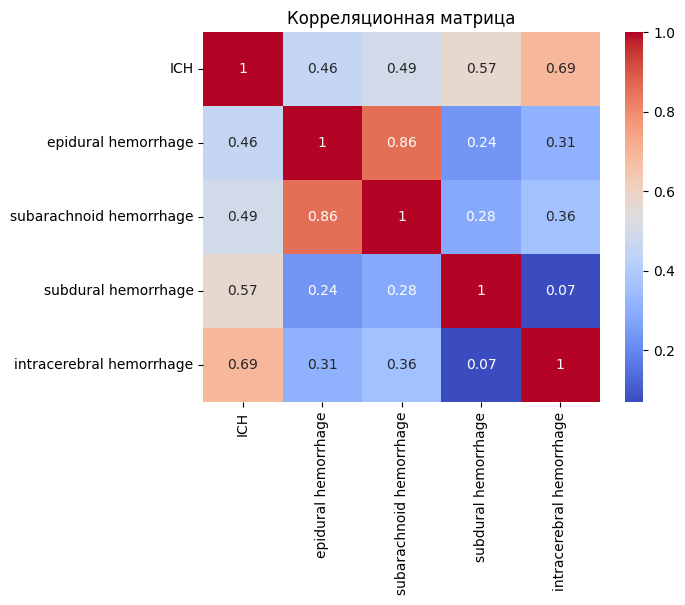

In [10]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [11]:
combined_df['ICH'].value_counts()

ICH
0    450
1    350
Name: count, dtype: int64

In [10]:
brain = get_dcm_serie(glob(find_folder(BASE, combined_df['study_uid'][11])+'/*')[-1])

Кол-во снимков = 388, uid=1.2.643.5.1.13.13.12.2.77.8252.10041113050410130506070505040205


['ORIGINAL', 'PRIMARY', 'AXIAL']


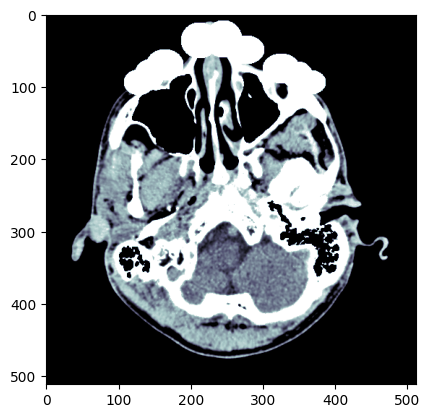

In [11]:
print(brain[166].ImageType)
plt.imshow(apply_voi_lut(brain[50].pixel_array, brain[50]), cmap='bone')

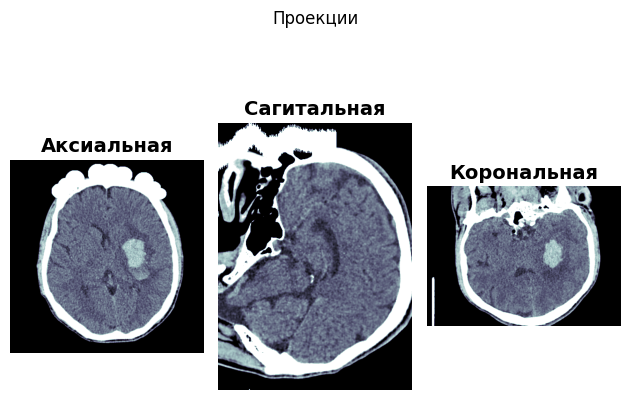

In [12]:
get_proections(brain)

In [40]:
brain[0].ImageType

['ORIGINAL', 'PRIMARY', 'AXIAL']

In [13]:
def get_3d_img(ds_list):
    ds_list = sorted(ds_list, key=lambda s: s.ImagePositionPatient[2])

    # Проверяем, что все срезы имеют одинаковые характеристики
    ps = ds_list[0].PixelSpacing
    ss = ds_list[0].SliceThickness
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]

    # Создаем трехмерный массив
    img_shape = list(ds_list[0].pixel_array.shape)
    img_shape.append(len(ds_list))
    img3d=np.zeros(img_shape)
    #print(ds_list[0].pixel_array.shape)

    # Заполняем трехмерный массив нашими снимками (срезами), увеличивая при этом их контрастность
    for i, s in enumerate(ds_list):
        img2d = apply_voi_lut(s.pixel_array, s)
        img3d[:,:,i] = img2d
    
    return img3d, sag_aspect

brain_3d, aspect = get_3d_img(brain)

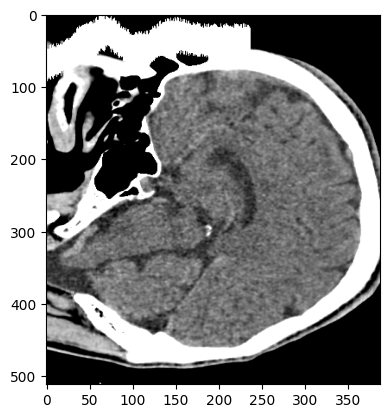

In [42]:
# Создаем фигуру и оси
fig, ax = plt.subplots()

# Отображаем изображение с установкой аспекта
ax.imshow(brain_3d[:,brain[0].pixel_array.shape[1]//2,:], cmap = 'grey', aspect = aspect)  # 'equal' для равных осей, 'auto' для автоматического определения

# Показываем изображение
plt.show()


# **Model**

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

device = torch.device("cuda:0")

def preprocess_series(series):
    # Пример предобработки: нормализация
    series = (series - np.min(series)) / (np.max(series) - np.min(series))
    return series.astype('float16')


class MedicalNet(nn.Module):
    def __init__(self):
        super(MedicalNet, self).__init__()
        self.model = models.video.r3d_18(models.video.R3D_18_Weights.KINETICS400_V1)
        # Изменение количества входных каналов в первом сверточном слое
        self.model.stem[0] = nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return self.model(x)

model = MedicalNet().to(device)

In [259]:
series = None
brain = None

In [12]:

import gc
gc.collect()

9

In [13]:
import torch
torch.cuda.empty_cache()

In [14]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Кол-во обучаемых параметров: \n{}".format(pytorch_total_params))

Кол-во обучаемых параметров: 
33166785


In [26]:
patology_ids = combined_df.sort_values(by = 'ICH')['study_uid'][:10]
normal_ids = combined_df.sort_values(by = 'ICH', ascending=False)['study_uid'][:10]

In [27]:
pathologies = []
normals = []
for el in patology_ids:
    pathologies.append(get_stacked_structures_from_dicom(get_dcm_serie(glob(find_folder(BASE, el)+'/*')[0])))
for el in normal_ids:
    normals.append(get_stacked_structures_from_dicom(get_dcm_serie(glob(find_folder(BASE, el)+'/*')[0])))

Кол-во снимков = 272, uid=1.2.643.5.1.13.13.12.2.77.8252.12300404150902100410090115003456
Кол-во снимков = 388, uid=1.2.643.5.1.13.13.12.2.77.8252.13131106101514030510140208130704
Кол-во снимков = 37, uid=1.2.643.5.1.13.13.12.2.77.8252.04040907010700150112030002120613
Кол-во снимков = 601, uid=1.2.643.5.1.13.13.12.2.77.8252.14010406090103020101000708140712
Кол-во снимков = 581, uid=1.2.643.5.1.13.13.12.2.77.8252.04101112000314051106040905070004
Кол-во снимков = 601, uid=1.2.643.5.1.13.13.12.2.77.8252.09151102010502111202120600091209
Кол-во снимков = 301, uid=1.2.643.5.1.13.13.12.2.77.8252.00131412031109141206110502060113
Кол-во снимков = 745, uid=1.2.643.5.1.13.13.12.2.77.8252.14041113090906120000050710120413
Кол-во снимков = 626, uid=1.2.643.5.1.13.13.12.2.77.8252.01151103121000090712060015031013
Кол-во снимков = 207, uid=1.2.643.5.1.13.13.12.2.77.8252.15101504091501071310011106120802
Кол-во снимков = 81, uid=1.2.643.5.1.13.13.12.2.77.8252.06000710020011090113150209031410
Кол-во снимк

In [266]:
print(len(normals))

11


In [28]:
data = pathologies+normals
labels = [1 for x in range(len(pathologies))] + [0 for x in range(len(normals))]
print(labels)
data = [preprocess_series(series) for series in data]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
# Определение Dataset
class MedicalDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        series = self.data[idx]
        label = self.labels[idx]
        series = torch.tensor(series, dtype=torch.float16)
        label = torch.tensor(label, dtype=torch.long)
        return series, label
    
dataset = MedicalDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [285]:
pathologies = None
normals = None
#data = None

In [32]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Инициализация GradScaler для смешанных точностей
scaler = GradScaler()

In [33]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')

Epoch 1/25, Loss: 1.1691096305847168
Epoch 2/25, Loss: 1.9664079546928406
Epoch 3/25, Loss: 0.9526752233505249
Epoch 4/25, Loss: 0.7385912656784057
Epoch 5/25, Loss: 0.7584332227706909
Epoch 6/25, Loss: 0.5914540708065033
Epoch 7/25, Loss: 0.5660203099250793
Epoch 8/25, Loss: 0.6824198603630066
Epoch 9/25, Loss: 0.7544211983680725
Epoch 10/25, Loss: 0.6414669513702392
Epoch 11/25, Loss: 0.7352388620376586
Epoch 12/25, Loss: 0.658983850479126
Epoch 13/25, Loss: 0.7278376579284668
Epoch 14/25, Loss: 0.6589138031005859
Epoch 15/25, Loss: 0.6756409406661987
Epoch 16/25, Loss: 0.6859101533889771
Epoch 17/25, Loss: 0.675051486492157
Epoch 18/25, Loss: 0.6524457931518555
Epoch 19/25, Loss: 0.7007332801818847
Epoch 20/25, Loss: 0.663094675540924
Epoch 21/25, Loss: 0.6656702995300293
Epoch 22/25, Loss: 0.659902822971344
Epoch 23/25, Loss: 0.6834918141365052
Epoch 24/25, Loss: 0.637519919872284
Epoch 25/25, Loss: 0.6523005604743958


In [44]:
patology_ids = combined_df.sort_values(by = 'ICH')['study_uid'][11:22]
normal_ids = combined_df.sort_values(by = 'ICH', ascending=False)['study_uid'][11:22]

pathologies = []
normals = []
for el in patology_ids:
    pathologies.append(get_stacked_structures_from_dicom(get_dcm_serie(glob(find_folder(BASE, el)+'/*')[0])))
for el in normal_ids:
    normals.append(get_stacked_structures_from_dicom(get_dcm_serie(glob(find_folder(BASE, el)+'/*')[0])))

test_data = pathologies+normals
labels = [1 for x in range(len(pathologies))] + [0 for x in range(len(normals))]
print(labels)
test_data = [preprocess_series(series) for series in test_data]

test_dataset = MedicalDataset(test_data, labels)

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

scaler = GradScaler()
accumulation_steps = 4  # Накопление градиентов от 4 мини-батчей

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(torch.device("cuda:0")), labels.to(torch.device("cuda:0"))
        with autocast():
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')

Кол-во снимков = 221, uid=1.2.643.5.1.13.13.12.2.77.8252.12060513100602030606001204040013
Кол-во снимков = 219, uid=1.2.643.5.1.13.13.12.2.77.8252.05140300040802150601061015021404
Кол-во снимков = 256, uid=1.2.643.5.1.13.13.12.2.77.8252.08090912070715030004010404030011
Кол-во снимков = 267, uid=1.2.643.5.1.13.13.12.2.77.8252.05070713031306061204110912030200
Кол-во снимков = 232, uid=1.2.643.5.1.13.13.12.2.77.8252.07010512101302030602100900060802
Кол-во снимков = 671, uid=1.2.643.5.1.13.13.12.2.77.8252.13150115061212031103011201000115
Кол-во снимков = 401, uid=1.2.643.5.1.13.13.12.2.77.8252.13020210060304080400010010011209
Кол-во снимков = 108, uid=1.2.643.5.1.13.13.12.2.77.8252.01101105070507021501050004080711
Кол-во снимков = 226, uid=1.2.643.5.1.13.13.12.2.77.8252.12100513100201040015060710040202
Кол-во снимков = 745, uid=1.2.643.5.1.13.13.12.2.77.8252.13130615111115041403020608080815
Кол-во снимков = 276, uid=1.2.643.5.1.13.13.12.2.77.8252.09151008040512020814030114001209
Кол-во сни

In [48]:
from datetime import datetime
now = datetime.now()
additional_info = 'mednet_128_128_128_first'
torch.save(model, r"nn_models\test_"+f'{now.month}_{now.day}_{now.hour}_{now.minute}' +additional_info)

torch.Size([1, 3, 128, 150, 150])


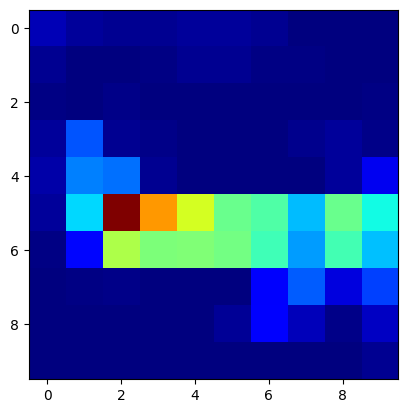

In [35]:
import torch.nn.functional as F

input_tensor = data[1]
input_tensor = torch.tensor(input_tensor, dtype=torch.float32).unsqueeze(0).to(device)
print(input_tensor.shape)

def get_grad_cam(model, input_tensor, target_layer, target_class):
    # Убедитесь, что модель в режиме оценки
    model.eval()

    # Хуки для извлечения градиентов и активаций
    activations = None
    gradients = None

    def hook_fn_forward(module, input, output):
        nonlocal activations
        activations = output

    def hook_fn_backward(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    # Получите целевой слой
    target_layer = model.get_submodule(target_layer)

    # Зарегистрируйте хуки
    forward_hook = target_layer.register_forward_hook(hook_fn_forward)
    backward_hook = target_layer.register_backward_hook(hook_fn_backward)

    # Прямой проход
    input_tensor.requires_grad = True
    output = model(input_tensor)

    # Получите градиенты выходного класса относительно входного тензора
    model.zero_grad()
    output[0, target_class].backward(retain_graph=True)

    # Удалите хуки
    forward_hook.remove()
    backward_hook.remove()

    # Взвешенные активации
    weights = torch.mean(gradients, dim=[2, 3, 4], keepdim=True)
    cam = torch.sum(weights * activations, dim=1, keepdim=True)

    # Примените ReLU
    cam = F.relu(cam)

    # Нормализация
    cam = cam - cam.min()
    cam = cam / cam.max()

    return cam

# Пример использования
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MedicalNet().to(device)

# Пример входного тензора (замените на ваш реальный входной тензор)
#input_tensor = torch.randn(1, 3, 180, 150, 150).to(device)

# Целевой слой и класс
target_layer = 'model.layer4.1.conv2'
target_class = 0

# Получите карту внимания
cam = get_grad_cam(model, input_tensor, target_layer, target_class)

# Визуализация карты внимания
cam = cam.cpu().detach().numpy()

plt.imshow(cam[0, 0, :, :, :].mean(axis=0), cmap='jet')
plt.show()

In [98]:
print(cam.shape)

(1, 1, 23, 10, 10)


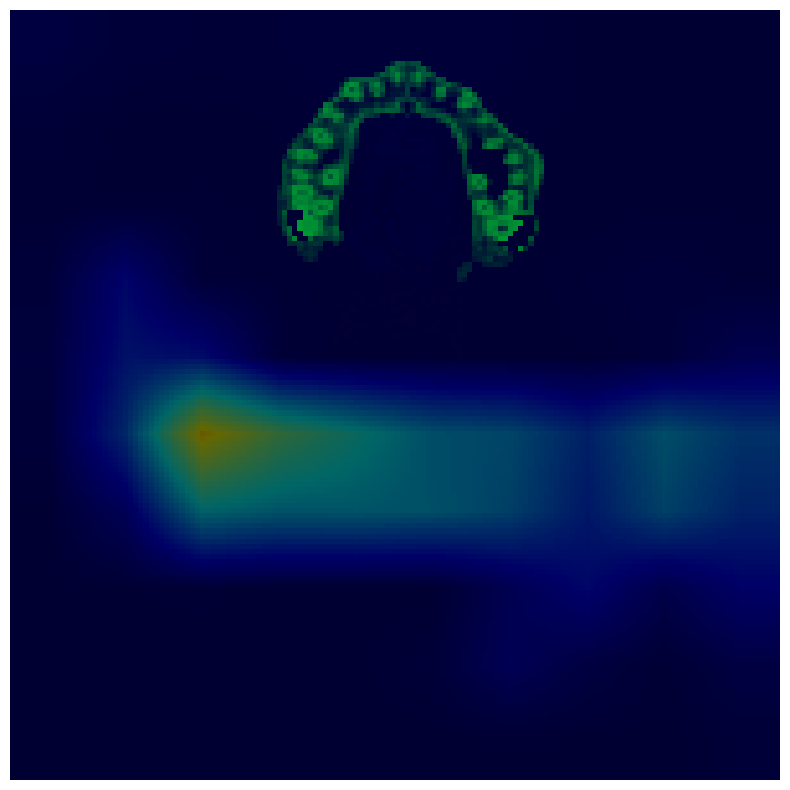

In [37]:
# Усреднение по временной оси для получения 2D карты внимания
cam_2d = cam[0, 0, :, :, :].mean(axis=0)

# Преобразование карты внимания в изображение
cam_2d = cv2.resize(cam_2d, (150, 150))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_2d), cv2.COLORMAP_JET)

# Пример исходного изображения (замените на ваше реальное изображение)
original_image = input_tensor[0, :, 0, :, :].cpu().permute(1, 2, 0).detach().numpy()
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
original_image = (original_image * 255).astype(np.uint8)

# Наложение карты внимания на исходное изображение
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
superimposed_img = heatmap * 0.4 + original_image * 0.6

# Визуализация с использованием matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img.astype(np.uint8))
plt.axis('off')
plt.show()

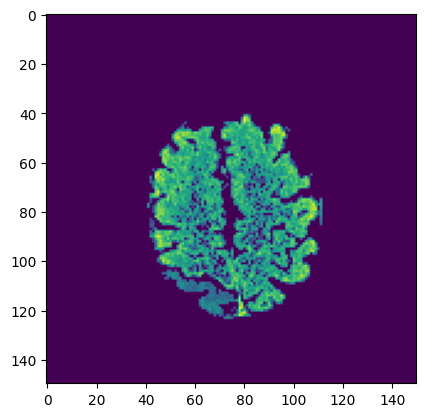

In [24]:
plt.imshow(pathologies[0][0][90])

# **Experiments, skull stripping**

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


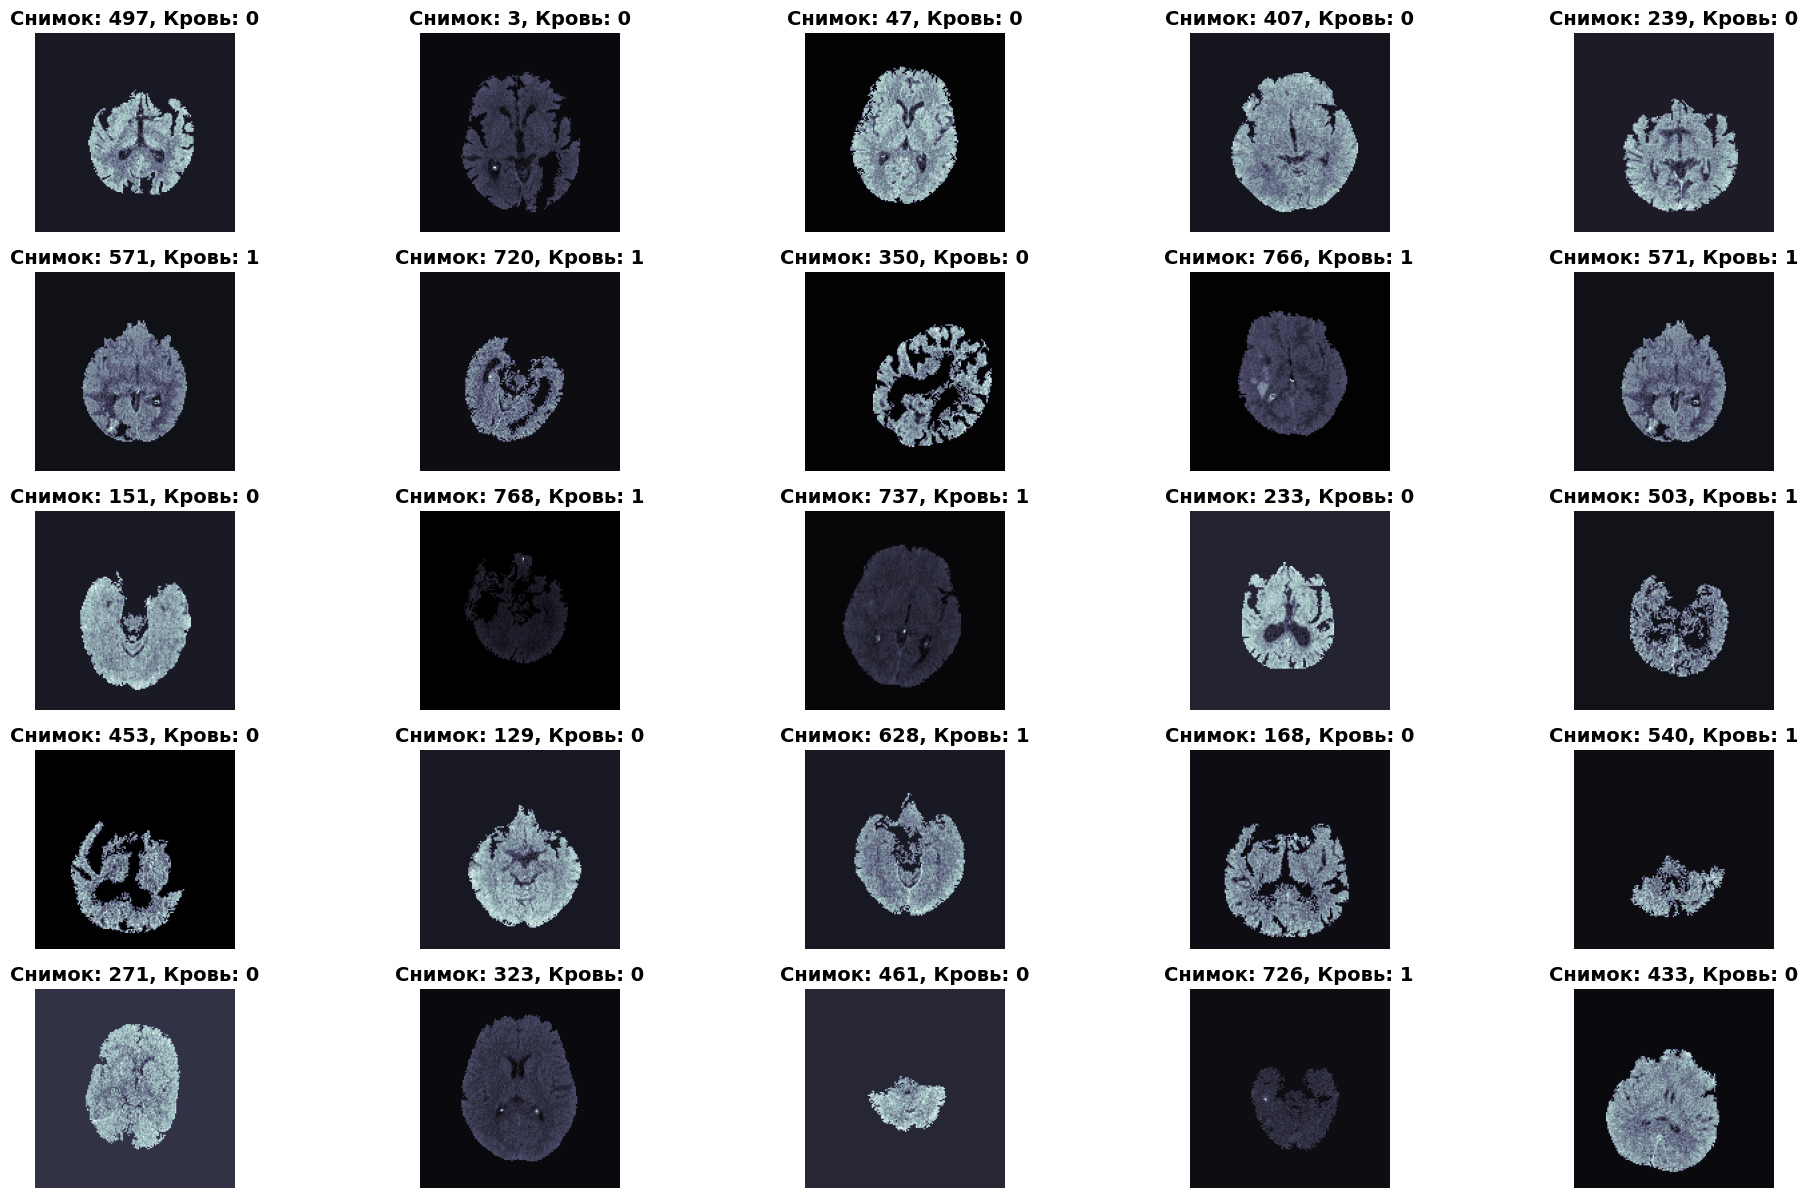

In [169]:
get_many_brain_proections(combined_df, rows = 5, cols = 5)

Кол-во снимков = 244, uid=1.2.643.5.1.13.13.12.2.77.8252.08111104011208001215100909131107


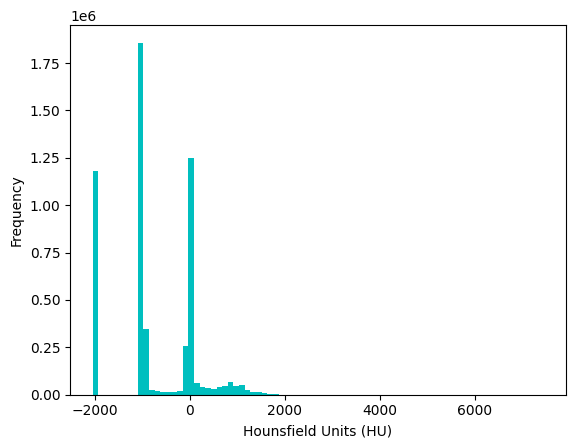

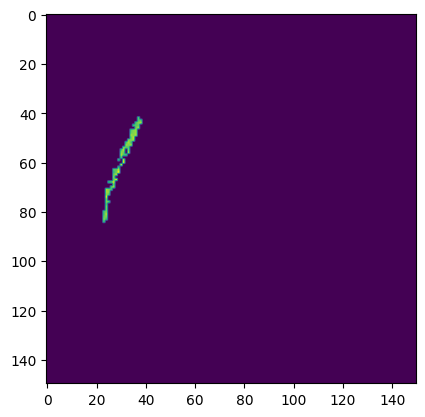

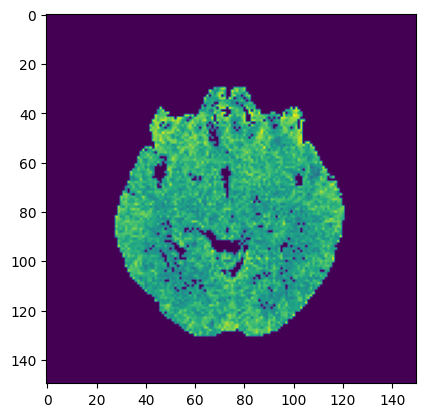

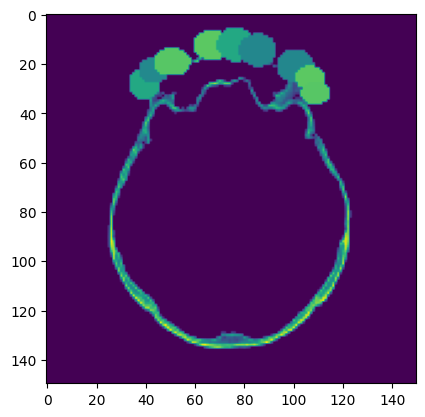

In [193]:
patient_num = 35

patient_dicoms = get_dcm_serie(glob(find_folder(BASE, combined_df['study_uid'][patient_num])+'/*')[-1])
mid_slice = len(patient_dicoms) // 2

patient_pixels = resize_dicom_list(patient_dicoms)

plot_hu(patient_pixels)

blood_only = get_structures_only(patient_pixels, BLOOD_HU)
plt.imshow(blood_only[mid_slice])
plt.show()

brains_only = get_structures_only(patient_pixels, BRAIN_HU)
plt.imshow(brains_only[mid_slice])
plt.show()


bones_only = get_structures_only(patient_pixels, BONES_HU)
plt.imshow(bones_only[mid_slice])
plt.show()

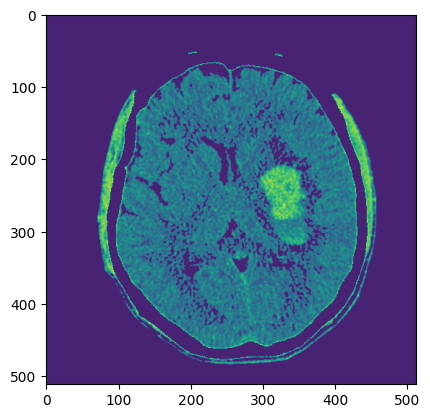

In [202]:
plt.imshow(apply_voi_lut(copied_pixels[-1], patient_dicoms[0]))